In [1]:
from contextlib import suppress
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.font_manager import fontManager, FontProperties

from util import ROOT_PATH

kwargs = dict(context='paper', palette='Set1', style='darkgrid', rc={'axes.unicode_minus': False})
with suppress(FileNotFoundError):
    font_path = '~/.local/share/fonts/cmunss.ttf'
    fontManager.addfont(font_path)
    prop = FontProperties(fname=font_path)
    kwargs |= dict(font=prop.get_name())
sns.set_theme(**kwargs)

In [2]:
def parse_tex(tex_path: Path, order: list[str] = None) -> tuple[list[str], list[str], dict[str, list[float]]]:
    with tex_path.open() as rf:
        tex_lines = [line for line in rf if not line.startswith('\\')]
    metrics, criteria, table = [], [], {}
    for i, line in enumerate(tex_lines):
        if i == 0:
            _, *criteria = line.split(' & ')
            criteria[-1] = criteria[-1].split()[0]
            table = {k: [] for k in criteria}
            continue
        metric, *values = line.split(' & ')
        values[-1] = values[-1].split()[0]
        metrics.append(metric)
        for y, value in enumerate(values):
            table[criteria[y]].append(float(value))
    if order is not None:
        ordered_table = {}
        for k, v in table.items():
            ordered_table[k] = [table[k][metrics.index(m)] for m in order]
        metrics = order
        table = ordered_table
    return metrics, criteria, table

In [3]:
metric_order = [
    'ROUGE-1', 'ROUGE-3', 'ROUGE-L', 'ROUGE-su*', 'mROUGE-we',
    'BertScore-p', 'BertScore-r', 'BertScore-f',
    'BLEU', 'CHRF', 'MultilingualMETEOR', 'CIDEr',
    'Length', 'Novel bi-gram', 'Repeated bi-gram',
    'Stats-coverage', 'Stats-compression', 'Stats-density'
]

judge_order = [
    'Qwen2.5-7B-Instruct', 'selene', 'prometheus',
    # 'M-Prom 7B', 'M-Prom 14B',
    # 'Qwen2.5 72B',
    'prometheus-8-7b', 'gpt-4o-mini',
    'gpt-4o'
]

In [4]:
correlations_path = ROOT_PATH / 'results' / 'correlation'

In [5]:
eu_metrics_path = correlations_path / 'eu' / 'metric_spear_corr.eu.tex'
metrics, criteria, eu_metric_data = parse_tex(eu_metrics_path, order=metric_order)
eu_judges_path = correlations_path / 'eu' / 'judge_spear_corr.eu.tex'
judges, _, eu_judge_data = parse_tex(eu_judges_path, order=judge_order)

In [6]:
es_metrics_path = correlations_path / 'es' / 'metric_spear_corr.es.tex'
_, _, es_metric_data = parse_tex(es_metrics_path, order=metric_order)
es_judges_path = correlations_path / 'es' / 'judge_spear_corr.es.tex'
_, _, es_judge_data = parse_tex(es_judges_path, order=judge_order)

In [7]:
x_labels = metrics + judges
y_labels = criteria
eu_data = {k: eu_metric_data[k] + eu_judge_data[k] for k in y_labels}
es_data = {k: es_metric_data[k] + es_judge_data[k] for k in y_labels}

In [8]:
x_label_map = {
    'MultilingualMETEOR':' mMETEOR',
    'Novel bi-gram': 'Novel 2-gram',
    'Repeated bi-gram': 'Rep. 2-gram',
    'Stats-coverage': 'Coverage',
    'Stats-compression': 'Compression',
    'Stats-density': 'Density',
    'Qwen2.5-7B-Instruct': 'Qwen2.5 7B',
    'selene': 'Selene Mini',
    'prometheus': 'Prom 2 7B',
    'prometheus-8-7b': 'Prom 2 8x7B',
    'gpt-4o-mini': 'GPT-4o mini',
    'gpt-4o': 'GPT-4o'
}
x_labels = [x_label_map.get(x, x) for x in x_labels]

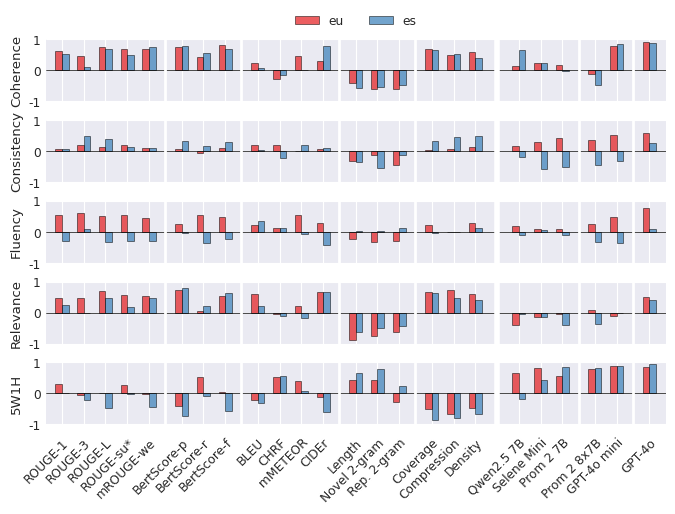

In [9]:
group_ends = [4, 7, 11, 14, 17, 20, 22, 25]  # Add indices where you want spaces (e.g., after ROUGE-L)
x = np.arange(len(x_labels), dtype=float)
gap_size = 0.5
for gap_idx in group_ends:
    x[gap_idx+1:] += gap_size
    if gap_idx == 17:
        x[gap_idx+1:] += gap_size

fig, axes = plt.subplots(len(y_labels), 1, figsize=(8, 5), height_ratios=[1] * len(y_labels))
fig.subplots_adjust(hspace=0.3)

bar_width = 0.3

for idx, criterion in enumerate(y_labels):
    ax = axes[idx]

    ax.grid(True, axis='x', zorder=0)
    ax.grid(True, axis='y', zorder=0)

    ax.bar(x - bar_width/2, eu_data[criterion], bar_width, label='eu', alpha=0.7, edgecolor='black', linewidth=0.5, zorder=2)
    ax.bar(x + bar_width/2, es_data[criterion], bar_width, label='es', alpha=0.7, edgecolor='black', linewidth=0.5, zorder=2)
    ax.axhline(y=0, color='black', linewidth=0.5)
    diff = 0
    for gap_idx in group_ends:
        if gap_idx == 17:
            ax.axvline(x=gap_idx+1+diff, color='white', linewidth=4)
            diff += gap_size
        else:
            ax.axvline(x=gap_idx+0.75+diff, color='white', linewidth=2)
        diff += gap_size

    ax.set_ylim(-1, 1)  # Correlation range
    ax.set_xlim(min(x) - 0.75, max(x) + 0.75)

    # Remove box, keep only bottom spine
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Add criterion name on the left
    ax.set_ylabel(criterion, rotation=90, ha='center', va='bottom')

    # Add y ticks
    ax.tick_params(axis='y', which='both', left=True, labelleft=True, right=False, labelright=False, length=0)

    # Set x-ticks for all plots to get consistent grid lines
    ax.set_xticks(x)

    # Only show x-labels for the bottom plots
    if idx == len(y_labels) - 1:
        ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
    else:
        ax.set_xticklabels([])

axes[0].legend(bbox_to_anchor=(0.5, 1.3), loc='center', ncol=2, frameon=False)

plt.savefig(str(correlations_path / 'spear_corr.bars.pdf'), dpi=300, bbox_inches='tight')